# Train WaveNet

In [1]:
from wavenet_model import WaveNetModel, ExpandingWaveNetModel
from wavenet_training import AudioFileLoader, WaveNetOptimizer

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Setup Model

In [2]:
train_samples = ["train_samples/clarinet_g.wav"]
sampling_rate = 11025
init_model = None

layers = 5
blocks = 2
classes = 256
dilation_channels = 32
residual_channels = 32
skip_channels = 64
kernel_size = 2
output_length = 2
dtype = torch.FloatTensor
ltype = torch.LongTensor

use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

In [3]:
model = ExpandingWaveNetModel(layers=layers,
                              blocks=blocks,
                              dilation_channels=dilation_channels,
                              residual_channels=residual_channels,
                              skip_channels=skip_channels,
                              classes=classes,
                              output_length=output_length,
                              kernel_size=kernel_size,
                              dtype=dtype)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("receptive_field: ", model.receptive_field)
print("parameter count: ", model.parameter_count())

if init_model != None:
    if use_cuda:
        model.load_state_dict(torch.load(init_model))
    else:
        # move to cpu
        model.load_state_dict(torch.load(init_model, map_location=lambda storage, loc: storage))

data_loader = AudioFileLoader(train_samples,
                              classes=classes,
                              receptive_field=model.receptive_field,
                              target_length=model.output_length,
                              dtype=dtype,
                              ltype=ltype,
                              sampling_rate=sampling_rate)

receptive field:  2
receptive field:  4
receptive field:  8
receptive field:  16
receptive field:  32
receptive field:  33
receptive field:  35
receptive field:  39
receptive field:  47
receptive field:  63
receptive_field:  65
parameter count:  78144
total duration of training data:  66194.25  samples


Variable containing:

Columns 0 to 9 
-0.0716 -0.1488  0.1384 -0.1002 -0.1635 -0.3812  0.3444 -0.2968 -0.2832 -0.3584
-0.1198 -0.1531  0.1214 -0.1282 -0.1901 -0.3288  0.4087 -0.3958 -0.2920 -0.2873

Columns 10 to 19 
 0.1099 -0.0552 -0.1125  0.4960 -0.2034  0.3708  0.3888 -0.1020 -0.2491 -0.0130
 0.0618  0.0623 -0.1169  0.5616 -0.1504  0.3275  0.3484 -0.0070 -0.3163  0.0450

Columns 20 to 29 
-0.0084  0.4871 -0.2016 -0.1376  0.0839 -0.2572 -0.1119  0.0307  0.0237  0.5932
 0.1875  0.4807 -0.2547 -0.2128 -0.0225 -0.3104 -0.0484 -0.0159 -0.0604  0.7159

Columns 30 to 39 
 0.0513 -0.3515 -0.1883  0.2738  0.3914 -0.0371  0.3215  0.1144  0.5590 -0.4359
 0.2110 -0.1930 -0.0926  0.2612  0.3929 -0.0698  0.3782  0.1982  0.4664 -0.4410

Columns 40 to 49 
 0.0378  0.1157  0.5307  0.1166 -0.1300 -0.1705 -0.3772 -0.4618 -0.3422 -0.2554
 0.1883 -0.0836  0.5610  0.1797 -0.1977 -0.0920 -0.5036 -0.5399 -0.3843 -0.1962

Columns 50 to 59 
 0.3084 -0.4194  0.2671 -0.1682  0.5996  0.1449 -0.2970  0.2771  0.

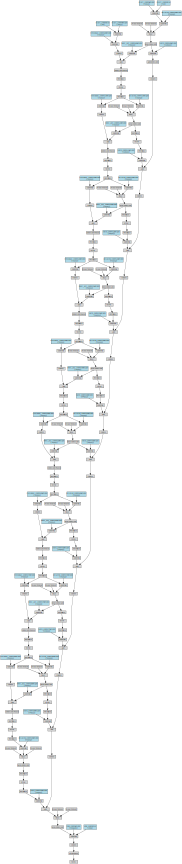

In [4]:
from visualize import make_dot
from torch.autograd import Variable

input = Variable(torch.rand(1, 1, 256))
output = model(input)
params = dict(model.named_parameters())
#output.backward()
print(output)

make_dot(output, params)

In [5]:

print("output length: ",  model.output_length)

data_loader.start_new_epoch()
start_data = data_loader.get_wavenet_minibatch([model.receptive_field], 
                                               model.receptive_field,
                                               model.output_length)[0]
start_data = start_data.squeeze()

plt.ion()
plt.plot(start_data[-200:].numpy())
plt.ioff()



output length:  2


TypeError: start_new_epoch() missing 2 required positional arguments: 'segments_per_chunk' and 'examples_per_segment'

## Train Model

In [ ]:
learning_rate = 0.03
mini_batch_size = 32
report_interval = 4
validation_interval = 64
snapshot_interval = 512
epochs = 250
segments_per_chunk=16
examples_per_segment=32
validation_segments = 8
examples_per_validation_segment = 8
model_path = "model_parameters/clarinet_g_7-3-256-32-32-64-2"

In [ ]:
def report_callback(opt):
    ax.clear()
    ax.grid(linestyle="--", axis="y")
    ax.plot(opt.loss_positions, opt.losses)
    ax.plot(opt.validation_result_positions, opt.validation_results)
    fig.canvas.draw()
    
#def test_callback(test_results, positions):
    
optimizer = WaveNetOptimizer(model,
                             data=data_loader,
                             validation_segments=validation_segments,
                             examples_per_validation_segment=examples_per_validation_segment,
                             report_callback=report_callback,
                             report_interval=report_interval,
                             validation_interval=validation_interval,
                             validation_report_callback=None,
                             snapshot_interval=snapshot_interval,
                             snapshot_file=model_path)


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

print('start training...')
tic = time.time()
optimizer.train(learning_rate=learning_rate,
                minibatch_size=mini_batch_size,
                epochs=epochs,
                segments_per_chunk=segments_per_chunk,
                examples_per_segment=examples_per_segment)
toc = time.time()
print('Training took {} seconds.'.format(toc-tic))

In [ ]:
optimizer.step_times

In [ ]:
torch.save(model.state_dict(), model_path)

In [6]:
a = torch.rand(4)
for i, v in enumerate(a):
    print(i, v)

0 0.052906621247529984
1 0.6008393168449402
2 0.9403193593025208
3 0.06768510490655899
